In [10]:
import pandas as pd

In [11]:
import os
print(os.getcwd())


c:\Users\21td031\Documents\motion2music


In [ ]:
# import os
# from scripts.extract_pose import extract_pose_from_video

# input_dir = "data/raw/"
# output_dir = "data/features/default"
# os.makedirs(output_dir, exist_ok=True)

# video_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".mp4")])

# for filename in video_files:
#     video_path = os.path.join(input_dir, filename)
#     output_csv = os.path.join(output_dir, filename.replace(".mp4", ".csv"))
#     print(f"抽出中: {filename}")
#     extract_pose_from_video(video_path, output_csv)


In [13]:
import os
import pandas as pd
from scripts.preprocess import normalize_pose_df

input_dir = "data/features/default"
output_dir = "data/normalized_features/default"
os.makedirs(output_dir, exist_ok=True)

csv_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])

for fname in csv_files:
    input_path = os.path.join(input_dir, fname)
    output_path = os.path.join(output_dir, fname.replace(".csv", "_normalized.csv"))

    df = pd.read_csv(input_path)
    normalized_df = normalize_pose_df(df)
    normalized_df.to_csv(output_path, index=False)

    print(f"✔ 正規化完了: {fname} → {output_path}")


ImportError: cannot import name 'normalize_pose_df' from 'scripts.preprocess' (c:\Users\21td031\Documents\motion2music\scripts\preprocess.py)

In [14]:
import pandas as pd

df = pd.read_csv("data/normalized_features/default/久世_normalized.csv")
desc = df.describe()

print("各列の平均 (should be ≈ 0):")
print(desc.loc["mean"].round(3))

print("\n標準偏差 (全体で ≈ 1程度に収まると理想):")
print(desc.loc["std"].round(3))


各列の平均 (should be ≈ 0):
P0_x     0.007
P0_y    -1.177
P1_x     0.074
P1_y    -1.229
P2_x     0.111
         ...  
P30_y    1.250
P31_x   -0.042
P31_y    1.384
P32_x   -0.196
P32_y    1.389
Name: mean, Length: 66, dtype: float64

標準偏差 (全体で ≈ 1程度に収まると理想):
P0_x     0.260
P0_y     0.111
P1_x     0.241
P1_y     0.104
P2_x     0.235
         ...  
P30_y    0.256
P31_x    0.170
P31_y    0.172
P32_x    0.242
P32_y    0.245
Name: std, Length: 66, dtype: float64


In [15]:
import os
import pandas as pd
import numpy as np

input_dir = "data/normalized_features/default"
csv_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])

all_data = []

for fname in csv_files:
    df = pd.read_csv(os.path.join(input_dir, fname))
    
    # 欠損値がある行はスキップ（安全対策）
    df = df.dropna()
    
    # データを numpy に追加（フレーム単位）
    all_data.append(df.values)  # shape = [T, 66]

# 結合 → [全フレーム数, 66]
pose_array = np.vstack(all_data)

print("最終データ形状:", pose_array.shape)  # 例：[10000, 66]


最終データ形状: (2555, 66)


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# データをTensor化
X = torch.tensor(pose_array, dtype=torch.float32)

# ミニバッチ学習用データローダー
batch_size = 64
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [17]:
class MLP_AutoEncoder(nn.Module):
    def __init__(self, input_dim=66, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


In [18]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.2.2+cpu
False


In [19]:
model = MLP_AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]  # shape = [B, 66]
        x_hat, _ = model(x)

        loss = loss_fn(x_hat, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f}")


Epoch 1/50 - Loss: 22.9935
Epoch 2/50 - Loss: 7.3749
Epoch 3/50 - Loss: 6.4107
Epoch 4/50 - Loss: 3.2001
Epoch 5/50 - Loss: 2.1943
Epoch 6/50 - Loss: 2.8596
Epoch 7/50 - Loss: 3.4794
Epoch 8/50 - Loss: 2.8464
Epoch 9/50 - Loss: 2.5943
Epoch 10/50 - Loss: 1.0069
Epoch 11/50 - Loss: 1.1644
Epoch 12/50 - Loss: 1.6386
Epoch 13/50 - Loss: 2.1554
Epoch 14/50 - Loss: 1.4916
Epoch 15/50 - Loss: 1.3508
Epoch 16/50 - Loss: 1.0442
Epoch 17/50 - Loss: 0.6531
Epoch 18/50 - Loss: 0.6347
Epoch 19/50 - Loss: 0.5819
Epoch 20/50 - Loss: 0.7552
Epoch 21/50 - Loss: 0.7770
Epoch 22/50 - Loss: 1.2004
Epoch 23/50 - Loss: 1.4196
Epoch 24/50 - Loss: 1.3358
Epoch 25/50 - Loss: 0.7651
Epoch 26/50 - Loss: 1.0942
Epoch 27/50 - Loss: 1.0305
Epoch 28/50 - Loss: 1.7559
Epoch 29/50 - Loss: 1.7094
Epoch 30/50 - Loss: 1.1571
Epoch 31/50 - Loss: 1.8252
Epoch 32/50 - Loss: 1.4506
Epoch 33/50 - Loss: 1.3917
Epoch 34/50 - Loss: 1.6339
Epoch 35/50 - Loss: 0.8140
Epoch 36/50 - Loss: 0.9602
Epoch 37/50 - Loss: 1.6558
Epoch 38/

In [20]:
with torch.no_grad():
    _, latent_vecs = model(X)  # shape = [2555, latent_dim]
latent_vecs_np = latent_vecs.numpy()


In [21]:
latent_vecs_np  # shape = [2555, 16]


array([[-2.1823967 , -2.0897892 , -0.08912134, ...,  0.83671963,
         1.3083444 ,  2.251111  ],
       [-2.6946747 , -2.2333424 , -0.32569364, ...,  0.62290907,
         1.5510164 ,  2.6270034 ],
       [-1.4033426 , -1.2513822 ,  0.15776268, ...,  0.39787674,
         0.8996503 ,  1.5396513 ],
       ...,
       [-1.9370362 , -2.0488875 , -0.15141153, ..., -0.07560931,
         1.9606827 ,  1.6006904 ],
       [-1.9942683 , -2.0737424 , -0.12240249, ..., -0.07758778,
         2.0037034 ,  1.634151  ],
       [-2.0175455 , -2.0791094 , -0.09911734, ..., -0.06807638,
         2.020307  ,  1.6426103 ]], dtype=float32)

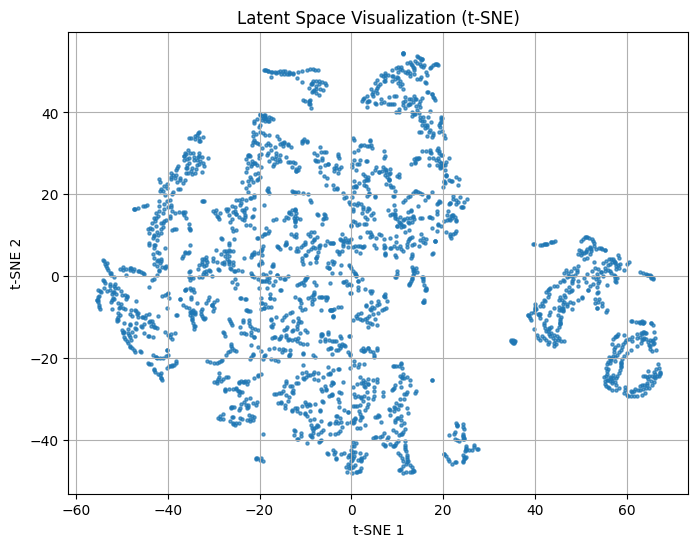

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d = tsne.fit_transform(latent_vecs_np)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=5, alpha=0.7)
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()


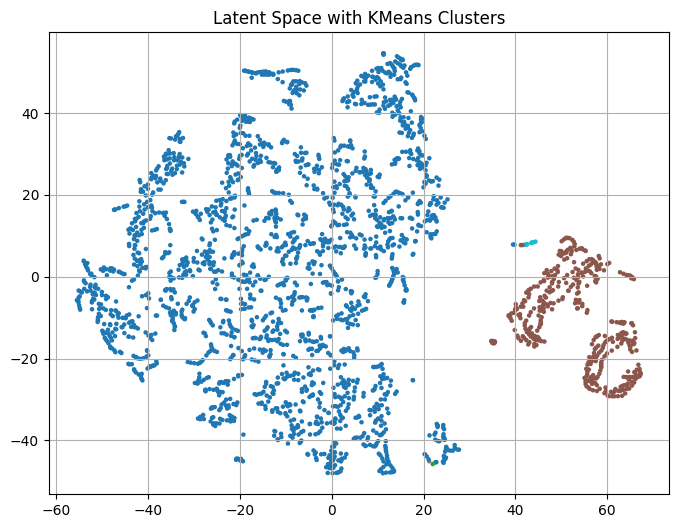

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(latent_vecs_np)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=5)
plt.title("Latent Space with KMeans Clusters")
plt.grid(True)
plt.show()


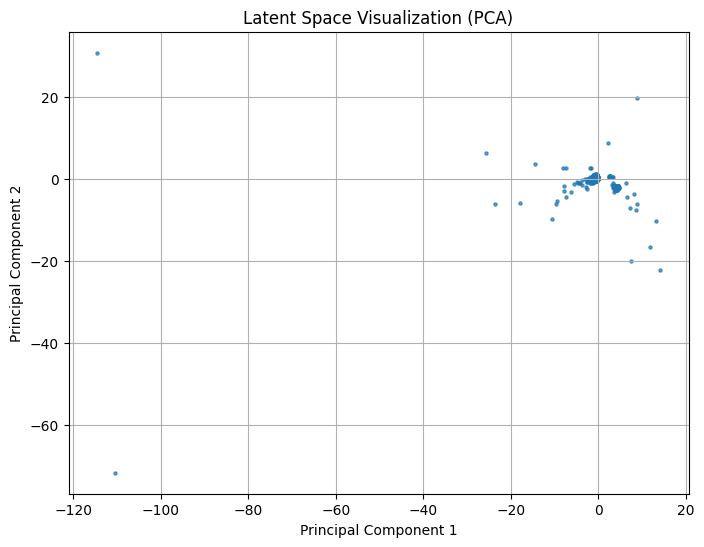

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vecs_np)

plt.figure(figsize=(8, 6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], s=5, alpha=0.7)
plt.title("Latent Space Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [25]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("累積寄与率:", pca.explained_variance_ratio_.sum())


Explained variance ratio: [0.663584  0.1922673]
累積寄与率: 0.8558513


In [26]:
import numpy as np

# pca.components_ → shape: [n_components, n_features]
# ここでは pca.components_[0] が PC1 の重みベクトル

feature_names = [f"P{i}_{axis}" for i in range(33) for axis in ['x', 'y']]

# 主成分1に強く寄与している特徴量 TOP10
pc1_weights = pca.components_[0]
pc1_top_idx = np.argsort(np.abs(pc1_weights))[::-1][:10]

print("主成分1に最も寄与している特徴量:")
for i in pc1_top_idx:
    print(f"{feature_names[i]}: {pc1_weights[i]:.4f}")


主成分1に最も寄与している特徴量:
P4_y: 0.6074
P7_x: 0.4147
P3_y: 0.4103
P1_x: 0.2896
P5_y: 0.2098
P6_x: -0.1903
P6_y: -0.1726
P0_x: 0.1634
P2_x: -0.1376
P2_y: 0.1278


In [27]:
pc2_weights = pca.components_[1]
pc2_top_idx = np.argsort(np.abs(pc2_weights))[::-1][:10]

print("\n主成分2に最も寄与している特徴量:")
for i in pc2_top_idx:
    print(f"{feature_names[i]}: {pc2_weights[i]:.4f}")



主成分2に最も寄与している特徴量:
P0_x: 0.6220
P7_x: -0.3977
P7_y: -0.3846
P0_y: 0.3793
P1_x: 0.2581
P2_x: 0.1701
P3_y: -0.1641
P3_x: -0.1281
P4_y: 0.0827
P5_x: 0.0627


In [28]:
# エンコーダの重みを取得
first_linear = model.encoder[0]  # 66 → 128
second_linear = model.encoder[2] # 128 → 16

# 重み行列の取得（[出力, 入力] 形式）
W1 = first_linear.weight.detach().numpy()   # shape: (128, 66)
W2 = second_linear.weight.detach().numpy()  # shape: (16, 128)

# 確認
print("W1 shape:", W1.shape)
print("W2 shape:", W2.shape)


W1 shape: (128, 66)
W2 shape: (16, 128)


In [30]:
W_combined = np.dot(W2, W1)  # shape: (16, 66)
W_combined.shape


(16, 66)

In [31]:
# 入力特徴量の名前（例：P0_x, P0_y, ..., P32_y）
feature_names = [f"P{i}_{axis}" for i in range(33) for axis in ['x', 'y']]

# 潜在次元の名前（例：z0, z1, ..., z15）
latent_names = [f"z{i}" for i in range(W_combined.shape[0])]

# 確認
print("特徴量数:", len(feature_names))
print("潜在次元数:", len(latent_names))


特徴量数: 66
潜在次元数: 16


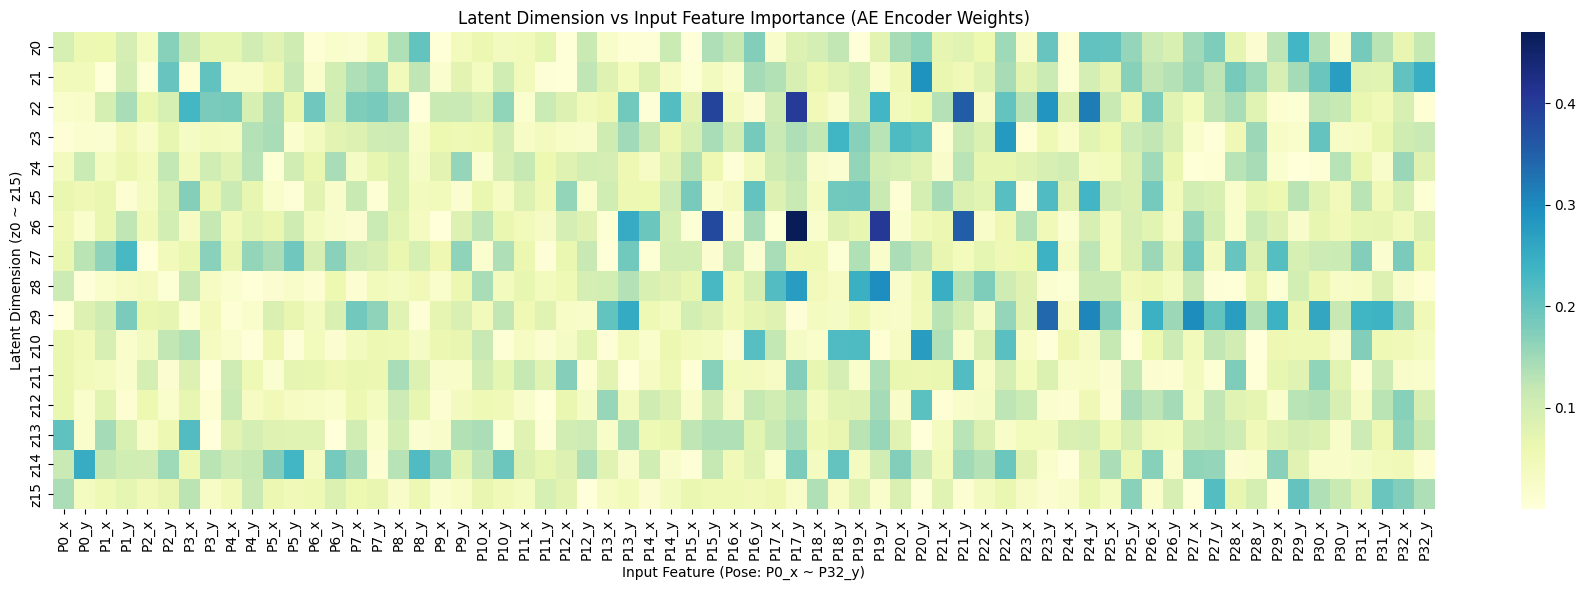

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 重みの絶対値をとることで「影響の強さ」を可視化
weight_matrix = np.abs(W_combined)

plt.figure(figsize=(18, 6))
sns.heatmap(weight_matrix, 
            xticklabels=feature_names, 
            yticklabels=latent_names, 
            cmap="YlGnBu", 
            cbar=True)

plt.title("Latent Dimension vs Input Feature Importance (AE Encoder Weights)")
plt.xlabel("Input Feature (Pose: P0_x ~ P32_y)")
plt.ylabel("Latent Dimension (z0 ~ z15)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
